# Monte Carlo Integration: standard sampling, importance sampling, rejection sampling

Florent Leclercq,<br/>
Institute of Cosmology and Gravitation, University of Portsmouth,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib inline
from math import sin,pi

## The target pdf

In [2]:
def target_pdf(x):
    return sin(x)*sin(x)
target_pdf=np.vectorize(target_pdf)

In [3]:
a=0.
b=pi
x_arr=np.arange(a,b,(b-a)/100.)
f_arr=np.array([target_pdf(x) for x in x_arr])

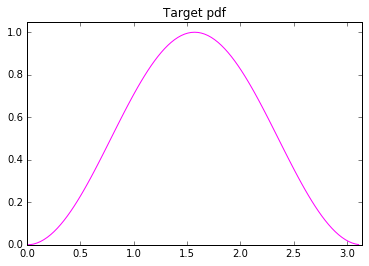

In [4]:
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,color='magenta')
plt.title("Target pdf")
plt.show()

In [5]:
trueI=quad(target_pdf,a,b)[0]
trueI

1.5707963267948966

## Standard Monte Carlo integration

In [6]:
Nsamp=100

In [7]:
randoms=np.random.uniform(a,b,Nsamp)
samples=target_pdf(randoms)

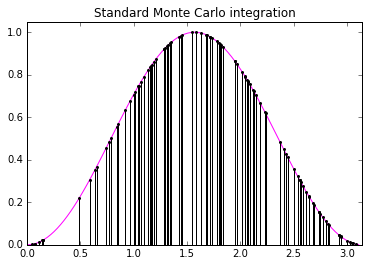

In [8]:
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,color='magenta')
markerline, stemlines, baseline = plt.stem(randoms,samples)
plt.setp(markerline, color='black', markersize=3., markeredgewidth = 0.)
plt.setp(stemlines, color='black')
plt.title("Standard Monte Carlo integration")
plt.show()

In [9]:
StandardMonteCarloI=np.sum(samples)*(b-a)/Nsamp
StandardMonteCarloI

1.7226742693981894

## Importance sampling

In [10]:
Nsamp=1000

In [11]:
gaussian=norm(loc=(b-a)/2,scale=0.5)

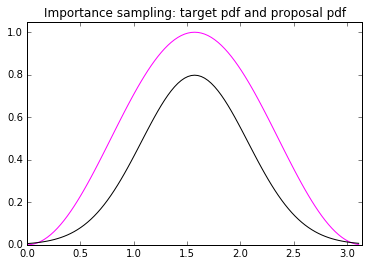

In [12]:
plt.xlim(a,b)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,color='magenta')
plt.plot(x_arr,gaussian.pdf(x_arr),color='black')
plt.title("Importance sampling: target pdf and proposal pdf")
plt.show()

In [13]:
randoms=gaussian.rvs(size=Nsamp)
samples=target_pdf(randoms)/gaussian.pdf(randoms)

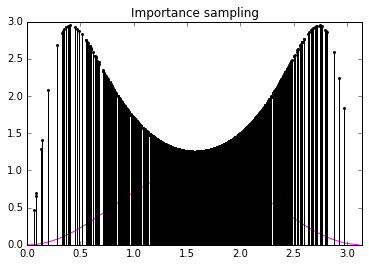

In [14]:
plt.xlim(a,b)
plt.ylim(0,3.)
plt.plot(x_arr,f_arr,color='magenta')
markerline, stemlines, baseline = plt.stem(randoms,samples,color='black')
plt.setp(markerline, color='black', markersize=3., markeredgewidth = 0.)
plt.setp(stemlines, color='black')
plt.title("Importance sampling")
plt.show()

In [15]:
ImportanceI=np.sum(samples)/Nsamp
ImportanceI

1.6750553663081333

## Rejection sampling

In [16]:
Nsamp=1000

In [17]:
upperbound=1
xs=np.random.uniform(a,b,Nsamp)
ys=np.random.uniform(0,upperbound,Nsamp)

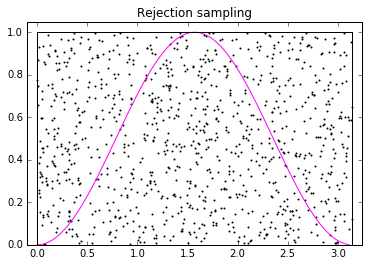

In [18]:
plt.xlim(a-0.1,b+0.1)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,color='magenta')
plt.scatter(xs,ys,s=4,marker='.',color='black')
plt.plot([a,b],[upperbound,upperbound],color='black')
plt.plot([a,a],[0,upperbound],color='black')
plt.plot([b,b],[0,upperbound],color='black')
plt.title("Rejection sampling")
plt.show()

In [19]:
randoms=xs[np.where(ys<=target_pdf(xs))]
samples=ys[np.where(ys<=target_pdf(xs))]

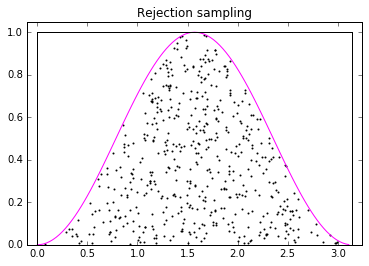

In [20]:
plt.xlim(a-0.1,b+0.1)
plt.ylim(0,1.05)
plt.plot(x_arr,f_arr,color='magenta')
plt.scatter(randoms,samples,s=4,marker='.',color='black')
plt.plot([a,b],[upperbound,upperbound],color='black')
plt.plot([a,a],[0,upperbound],color='black')
plt.plot([b,b],[0,upperbound],color='black')
plt.title("Rejection sampling")
plt.show()

In [21]:
fraction=float(len(samples))/Nsamp
fraction

0.517

In [22]:
fraction=float(len(samples))/Nsamp
RejectionI=fraction*upperbound*(b-a)
RejectionI

1.624203401905923